In [1]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import copy
%matplotlib inline

In [2]:
manualSeed = random.randint(1, 10000)  # fix seed
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  6311


In [3]:
coco_dataset = dset.CocoCaptions(
    root='inpainting/train2014',
    annFile='inpainting/annotations/captions_train2014.json',
    transform=transforms.ToTensor()
)

loading annotations into memory...
Done (t=0.76s)
creating index...
index created!


In [4]:
class DataIterator(object):
    """Data Iterator for COCO."""

    def __init__(
        self,
        train_path='inpainting/train2014',
        dev_path='inpainting/val2014',
        train_annotation_path='inpainting/annotations/captions_train2014.json',
        dev_annotation_path='inpainting/annotations/captions_val2014.json',
    ):
        """Initialize params."""
        self.train_path = train_path
        self.train_annotation_path = train_annotation_path
        self.dev_path = dev_path
        self.dev_annotation_path = dev_annotation_path
        print('Processing data ...')
        self._get_real_and_fake_images()

    def _get_real_and_fake_images(self):
        """Get real and fake images from path."""
        self.train_dataset = dset.CocoCaptions(
            root=self.train_path,
            annFile=self.train_annotation_path,
            transform=transforms.ToTensor()
        )
        self.valid_dataset = dset.CocoCaptions(
            root=self.dev_path, 
            annFile=self.dev_annotation_path,
            transform=transforms.ToTensor()
        )
        
        print('Populating training images & captions ...')
        train_images = []
        train_captions = []
        
        # There appears to be one image missing for some weird reason.
        try:
            for img, captions in self.train_dataset:
                train_images.append(img)
                train_captions.append(captions)
        except IOError:
            pass
        
        train_images = torch.stack(train_images)
        
        print('Populating validation images ...')
        valid_images = torch.stack([x[0] for x in self.valid_dataset])
        valid_captions = [x[1] for x in self.valid_dataset]
        
        print('Cropping 32x32 patch for training images ...')
        noisy_train_images = copy.deepcopy(train_images.numpy())
        noisy_train_images[:, :, 16:48, 16:48] = 0
        noisy_train_images = torch.from_numpy(noisy_train_images)

        print('Cropping 32x32 patch for validation images ...')
        noisy_valid_images = copy.deepcopy(valid_images.numpy())
        noisy_valid_images[:, :, 16:48, 16:48] = 0
        noisy_valid_images = torch.from_numpy(noisy_valid_images)
        
        self.train_images = train_images
        self.valid_images = valid_images

        self.noisy_train_images = noisy_train_images
        self.noisy_valid_images = noisy_valid_images
        
        self.num_train = len(train_images)
        self.num_valid = len(valid_images)

    def get_train_minibatch(self, index, batch_size):
        """Return a minibatch of real and fake examples."""
        real_examples = Variable(self.train_images[index: index + batch_size]).cuda()
        fake_examples = Variable(self.noisy_train_images[index: index + batch_size]).cuda()
        return real_examples, real_examples[:, :, 16:48, 16:48], fake_examples

    def get_valid_minibatch(self, index, batch_size):
        """Return a minibatch of real and fake examples."""
        real_examples = Variable(self.valid_images[index: index + batch_size]).cuda()
        fake_examples = Variable(self.noisy_valid_images[index: index + batch_size]).cuda()
        
        return real_examples, real_examples[:, :, 16:48, 16:48], fake_examples

In [5]:
iterator = DataIterator()

Processing data ...
loading annotations into memory...
Done (t=0.88s)
creating index...
index created!
loading annotations into memory...
Done (t=0.39s)
creating index...
index created!
Populating training images & captions ...
Populating validation images ...
Cropping 32x32 patch for training images ...
Cropping 32x32 patch for validation images ...


(-0.5, 63.5, 63.5, -0.5)

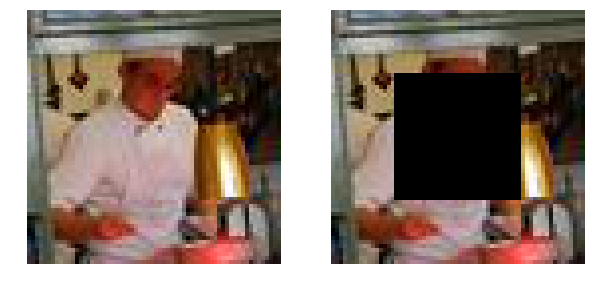

In [6]:
fig = plt.figure(figsize=(10, 5))
fig.add_subplot(1, 2, 1)
plt.imshow(iterator.train_images[14].numpy().transpose(1, 2, 0))
plt.axis('off')
fig.add_subplot(1, 2, 2)
plt.imshow(iterator.noisy_train_images[14].numpy().transpose(1, 2, 0))
plt.axis('off')

In [7]:
class UNetGeneratorSkip(nn.Module):
    """Generator module."""

    def __init__(self, start_filter):
        """Initialize generator."""
        super(UNetGeneratorSkip, self).__init__()

        #################################
        ####### DOWNSAMPLER MODULE ######
        #################################

        # 3 x 64 x 64
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=start_filter, kernel_size=4,
            stride=2, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(start_filter)

        # 16 x 32 x 32
        self.conv2 = nn.Conv2d(
            in_channels=start_filter, out_channels=start_filter * 2,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(start_filter * 2)

        # 32 x 16 x 16
        self.conv3 = nn.Conv2d(
            in_channels=start_filter * 2, out_channels=start_filter * 4,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(start_filter * 4)

        # 48 x 8 x 8
        self.conv4 = nn.Conv2d(
            in_channels=start_filter * 4, out_channels=start_filter * 8,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.bn4 = nn.BatchNorm2d(start_filter * 8)

        #################################
        ####### UPSAMPLER MODULE ########
        #################################

        # 64 x 4 x 4
        self.tconv1 = nn.Conv2d(
            in_channels=start_filter * 8, out_channels = 4000,
            kernel_size=4, bias=False
        )
        self.tbn1 = nn.BatchNorm2d(4000)

        # 48 x 8 x 8 + 48 x 8 x 8 = [96 x 8 x 8]
        self.tconv2 = nn.ConvTranspose2d(
            in_channels=4000, out_channels=start_filter * 8,
            kernel_size=4, stride=1, padding=0, bias=False
        )
        self.tbn2 = nn.BatchNorm2d(start_filter * 8)

        # 32 x 16 x 16 + 32 x 16 x 16 = [64 x 16 x 16]
        self.tconv3 = nn.ConvTranspose2d(
            in_channels=start_filter * 8, out_channels=start_filter * 4,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.tbn3 = nn.BatchNorm2d(start_filter * 4)
        
        self.tconv4 = nn.ConvTranspose2d(
            in_channels=start_filter * 4, out_channels=start_filter * 2,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.tbn4 = nn.BatchNorm2d(start_filter * 2)
        
        self.tconv5 = nn.ConvTranspose2d(
            in_channels=start_filter * 2, out_channels=start_filter,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.tbn5 = nn.BatchNorm2d(start_filter)
        
        self.tconv6 = nn.ConvTranspose2d(
            in_channels=start_filter, out_channels=3,
            kernel_size=5, stride=1, padding=2, bias=False
        )
        

    def forward(self, input):
        """Propogate input through the generator."""
        # Downsampling steps.
        conv1 = F.leaky_relu(self.bn1(self.conv1(input)), negative_slope=0.2, inplace=True)
        conv2 = F.leaky_relu(self.bn2(self.conv2(conv1)), negative_slope=0.2, inplace=True)
        conv3 = F.leaky_relu(self.bn3(self.conv3(conv2)), negative_slope=0.2, inplace=True)
        conv4 = F.leaky_relu(self.bn4(self.conv4(conv3)), negative_slope=0.2, inplace=True)
        
        # Upsampling steps.
        tconv1 = F.leaky_relu(self.tbn1(self.tconv1(conv4)), negative_slope=0.2, inplace=True)
        tconv2 = F.relu(self.tbn2(self.tconv2(tconv1)), True)
        tconv3 = F.relu(self.tbn3(self.tconv3(tconv2)), True)
        tconv4 = F.relu(self.tbn4(self.tconv4(tconv3)), True)
        tconv5 = F.relu(self.tbn5(self.tconv5(tconv4)), True)
        tconv6 = F.tanh(self.tconv6(tconv5))

        return tconv6

In [8]:
class Discriminator(nn.Module):
    """Discriminator."""

    def __init__(self, start_filter):
        """Initialize params."""
        super(Discriminator, self).__init__()

        # 3 x 32 x 32
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=start_filter, kernel_size=4,
            stride=2, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(start_filter)

        # 16 x 16 x 16
        self.conv2 = nn.Conv2d(
            in_channels=start_filter, out_channels=start_filter * 2,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(start_filter * 2)

        # 32 x 8 x 8
        self.conv3 = nn.Conv2d(
            in_channels=start_filter * 2, out_channels=start_filter * 4,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(start_filter * 4)

        # 48 x 4 x 4
        self.conv4 = nn.Conv2d(
            in_channels=start_filter * 4, out_channels=start_filter * 8,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.bn4 = nn.BatchNorm2d(start_filter * 8)

        # 64 x 2 x 2
        self.conv5 = nn.Conv2d(
            in_channels=start_filter * 8, out_channels=1,
            kernel_size=2, stride=1, padding=0, bias=False
        )

    def forward(self, input):
        """Propogate input through the network."""
        # Downsampling steps.
        # print 'input', input.size()
        conv1 = F.leaky_relu(self.bn1(self.conv1(input)), negative_slope=0.2, inplace=True)
        conv2 = F.leaky_relu(self.bn2(self.conv2(conv1)), negative_slope=0.2, inplace=True)
        conv3 = F.leaky_relu(self.bn3(self.conv3(conv2)), negative_slope=0.2, inplace=True)
        conv4 = F.leaky_relu(self.bn4(self.conv4(conv3)), negative_slope=0.2, inplace=True)
        conv4 = F.sigmoid(self.conv5(conv4))
        return conv4.squeeze()

In [9]:
generator = UNetGeneratorSkip(start_filter=32).cuda()
discriminator = Discriminator(start_filter=32).cuda()
optimizer_generator = optim.Adam(generator.parameters(), lr=1e-3, betas=(0.5, 0.999))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=1e-3, betas=(0.5, 0.999))
clamp_lower = -0.03
clamp_upper = 0.03
loss_criterion = nn.MSELoss().cuda()
save_dir = 'inpainting/samples'

In [10]:
def save_plots(epoch, fake_images, real_images, real_examples_full):
    j = np.random.randint(low=0, high=500)
    real_examples_full, real_examples, fake_images = iterator.get_valid_minibatch(j, 32)
    generator.eval()
    reconstructions = generator(fake_images)
    # fig = plt.figure(figsize=(20, 40))
    # idx = 1
    reconstructions = reconstructions.data.cpu().numpy()
    real = real_examples_full.data.cpu().numpy()
    real_copy = copy.deepcopy(real)
    real_copy[:, :, 16:48, 16:48] = reconstructions
    real_copy = torch.from_numpy(real_copy)
    real = torch.from_numpy(real)
    out_tensor = torch.zeros(1, real_copy.size(1), real_copy.size(2), real_copy.size(3))
    for zz, zzz in zip(real_copy[:10], real[:10]):
        out_tensor = torch.cat([out_tensor, zz.unsqueeze(0)])
        out_tensor = torch.cat([out_tensor, zzz.unsqueeze(0)])
    vutils.save_image(out_tensor[1:], 'inpainting/samples/epoch_%d_samples.png' % (epoch), normalize=True, scale_each=True, nrow=4)
    generator.train()

In [11]:
for i in range(15000):
    discriminator_losses = []
    generator_losses = []
    for j in range(0, iterator.num_train, 32):        
        ############################
        # (1) Update D network
        ############################
        
        for disc_updates in range(5):
            real_examples_full, real_examples, fake_images = iterator.get_train_minibatch(j, 32)
            D1 = discriminator(real_examples)
            fake = generator(fake_images)
            D2 = discriminator(fake)
            discriminator_loss = -.5 * ((D1 - D2).mean())
            optimizer_discriminator.zero_grad()
            discriminator_loss.backward()
            optimizer_discriminator.step()

            discriminator_losses.append(discriminator_loss.data[0])

            # clamp parameters to a cube
            for p in discriminator.parameters():
                p.data.clamp_(clamp_lower, clamp_upper)
        
        ############################
        # (2) Update G network
        ############################
        
        generated_images = generator(fake_images)
        generator_loss = -.5 * discriminator( generated_images).mean() + loss_criterion(generated_images, real_examples)
        optimizer_generator.zero_grad()
        generator_loss.backward()
        optimizer_generator.step()
        generator_losses.append(generator_loss.data[0])

    print('[%d] Loss_D: %f Loss_G: %f' % (i, np.mean(discriminator_losses), np.mean(generator_losses)))
    save_plots(i, fake_images, real_examples, real_examples_full)

/home/shared/anaconda3/envs/cs231n/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/shared/anaconda3/envs/cs231n/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[0] Loss_D: -0.142982 Loss_G: -0.074419
[1] Loss_D: -0.090142 Loss_G: -0.178838
[2] Loss_D: -0.133295 Loss_G: -0.119767
[3] Loss_D: -0.162644 Loss_G: -0.108215
[4] Loss_D: -0.203356 Loss_G: -0.102200
[5] Loss_D: -0.183330 Loss_G: -0.109460
[6] Loss_D: -0.193832 Loss_G: -0.100061
[7] Loss_D: -0.205734 Loss_G: -0.106303
[8] Loss_D: -0.206386 Loss_G: -0.109261
[9] Loss_D: -0.206553 Loss_G: -0.111002
[10] Loss_D: -0.206547 Loss_G: -0.111752
[11] Loss_D: -0.206907 Loss_G: -0.112656
[12] Loss_D: -0.206974 Loss_G: -0.113748
[13] Loss_D: -0.207003 Loss_G: -0.115063
[14] Loss_D: -0.206692 Loss_G: -0.116867
[15] Loss_D: -0.135593 Loss_G: -0.196461
[16] Loss_D: -0.074916 Loss_G: -0.166792
[17] Loss_D: -0.175209 Loss_G: -0.108742
[18] Loss_D: -0.176052 Loss_G: -0.110311
[19] Loss_D: -0.203588 Loss_G: -0.113906
[20] Loss_D: -0.205484 Loss_G: -0.117529
[21] Loss_D: -0.199336 Loss_G: -0.135181
[22] Loss_D: -0.117418 Loss_G: -0.156912
[23] Loss_D: -0.203070 Loss_G: -0.116342
[24] Loss_D: -0.202000 Los

[198] Loss_D: -0.172103 Loss_G: -0.137011
[199] Loss_D: -0.181594 Loss_G: -0.137561
[200] Loss_D: -0.192436 Loss_G: -0.134374
[201] Loss_D: -0.187553 Loss_G: -0.139131
[202] Loss_D: -0.185337 Loss_G: -0.135501
[203] Loss_D: -0.179222 Loss_G: -0.136124
[204] Loss_D: -0.187583 Loss_G: -0.135669
[205] Loss_D: -0.193900 Loss_G: -0.135484
[206] Loss_D: -0.194315 Loss_G: -0.135483
[207] Loss_D: -0.198530 Loss_G: -0.135603
[208] Loss_D: -0.169545 Loss_G: -0.152993
[209] Loss_D: -0.146384 Loss_G: -0.150541
[210] Loss_D: -0.161828 Loss_G: -0.137083
[211] Loss_D: -0.189448 Loss_G: -0.135575
[212] Loss_D: -0.187709 Loss_G: -0.136421
[213] Loss_D: -0.189286 Loss_G: -0.135585
[214] Loss_D: -0.171015 Loss_G: -0.143254
[215] Loss_D: -0.180383 Loss_G: -0.136445
[216] Loss_D: -0.193847 Loss_G: -0.136041
[217] Loss_D: -0.190648 Loss_G: -0.137012
[218] Loss_D: -0.184472 Loss_G: -0.135881
[219] Loss_D: -0.193689 Loss_G: -0.135717
[220] Loss_D: -0.171983 Loss_G: -0.138609
[221] Loss_D: -0.188930 Loss_G: -0

[394] Loss_D: -0.176692 Loss_G: -0.141012
[395] Loss_D: -0.190749 Loss_G: -0.139814
[396] Loss_D: -0.194257 Loss_G: -0.140011
[397] Loss_D: -0.186637 Loss_G: -0.140980
[398] Loss_D: -0.180367 Loss_G: -0.141540
[399] Loss_D: -0.170112 Loss_G: -0.142880
[400] Loss_D: -0.191260 Loss_G: -0.140564
[401] Loss_D: -0.187989 Loss_G: -0.140496
[402] Loss_D: -0.187172 Loss_G: -0.140770
[403] Loss_D: -0.188975 Loss_G: -0.140834
[404] Loss_D: -0.187029 Loss_G: -0.140660
[405] Loss_D: -0.181730 Loss_G: -0.141848
[406] Loss_D: -0.181727 Loss_G: -0.140775
[407] Loss_D: -0.175520 Loss_G: -0.143795
[408] Loss_D: -0.173456 Loss_G: -0.143982
[409] Loss_D: -0.189844 Loss_G: -0.139951
[410] Loss_D: -0.189271 Loss_G: -0.140474
[411] Loss_D: -0.187509 Loss_G: -0.140389
[412] Loss_D: -0.174084 Loss_G: -0.142898
[413] Loss_D: -0.187831 Loss_G: -0.140380
[414] Loss_D: -0.183054 Loss_G: -0.141260
[415] Loss_D: -0.189444 Loss_G: -0.140603
[416] Loss_D: -0.184933 Loss_G: -0.140959
[417] Loss_D: -0.171895 Loss_G: -0

[590] Loss_D: -0.182813 Loss_G: -0.142329
[591] Loss_D: -0.182009 Loss_G: -0.142787
[592] Loss_D: -0.176902 Loss_G: -0.142861
[593] Loss_D: -0.182614 Loss_G: -0.142255
[594] Loss_D: -0.186154 Loss_G: -0.142466
[595] Loss_D: -0.181363 Loss_G: -0.143384
[596] Loss_D: -0.176306 Loss_G: -0.142787
[597] Loss_D: -0.182378 Loss_G: -0.142494
[598] Loss_D: -0.181469 Loss_G: -0.142577
[599] Loss_D: -0.178237 Loss_G: -0.142980
[600] Loss_D: -0.187619 Loss_G: -0.142145
[601] Loss_D: -0.178145 Loss_G: -0.143028
[602] Loss_D: -0.176237 Loss_G: -0.144059
[603] Loss_D: -0.180407 Loss_G: -0.142123
[604] Loss_D: -0.181483 Loss_G: -0.142558
[605] Loss_D: -0.177458 Loss_G: -0.142939
[606] Loss_D: -0.179527 Loss_G: -0.143242
[607] Loss_D: -0.182778 Loss_G: -0.142260
[608] Loss_D: -0.179117 Loss_G: -0.142589
[609] Loss_D: -0.181099 Loss_G: -0.142107
[610] Loss_D: -0.183701 Loss_G: -0.142517
[611] Loss_D: -0.170670 Loss_G: -0.144905
[612] Loss_D: -0.188444 Loss_G: -0.141843
[613] Loss_D: -0.183955 Loss_G: -0

[786] Loss_D: -0.176166 Loss_G: -0.144517
[787] Loss_D: -0.187946 Loss_G: -0.142579
[788] Loss_D: -0.178352 Loss_G: -0.143877
[789] Loss_D: -0.175925 Loss_G: -0.143557
[790] Loss_D: -0.181968 Loss_G: -0.143395
[791] Loss_D: -0.185216 Loss_G: -0.143048
[792] Loss_D: -0.175825 Loss_G: -0.144357
[793] Loss_D: -0.148248 Loss_G: -0.150453
[794] Loss_D: -0.166037 Loss_G: -0.144559
[795] Loss_D: -0.170324 Loss_G: -0.146206
[796] Loss_D: -0.185986 Loss_G: -0.142077
[797] Loss_D: -0.190277 Loss_G: -0.142459
[798] Loss_D: -0.170947 Loss_G: -0.144668
[799] Loss_D: -0.183052 Loss_G: -0.142809
[800] Loss_D: -0.184177 Loss_G: -0.142568
[801] Loss_D: -0.175156 Loss_G: -0.145693
[802] Loss_D: -0.170461 Loss_G: -0.147889
[803] Loss_D: -0.172347 Loss_G: -0.143621
[804] Loss_D: -0.187496 Loss_G: -0.143128
[805] Loss_D: -0.153674 Loss_G: -0.146999
[806] Loss_D: -0.168173 Loss_G: -0.146042
[807] Loss_D: -0.165992 Loss_G: -0.146575
[808] Loss_D: -0.177390 Loss_G: -0.143602
[809] Loss_D: -0.184208 Loss_G: -0

[982] Loss_D: -0.182443 Loss_G: -0.143778
[983] Loss_D: -0.181107 Loss_G: -0.143656
[984] Loss_D: -0.182841 Loss_G: -0.143945
[985] Loss_D: -0.175788 Loss_G: -0.146818
[986] Loss_D: -0.173780 Loss_G: -0.148004
[987] Loss_D: -0.153873 Loss_G: -0.148372
[988] Loss_D: -0.169820 Loss_G: -0.145124
[989] Loss_D: -0.161120 Loss_G: -0.147852
[990] Loss_D: -0.171160 Loss_G: -0.144978
[991] Loss_D: -0.180357 Loss_G: -0.144284
[992] Loss_D: -0.178223 Loss_G: -0.143769
[993] Loss_D: -0.177689 Loss_G: -0.145234
[994] Loss_D: -0.177524 Loss_G: -0.145547
[995] Loss_D: -0.163567 Loss_G: -0.147262
[996] Loss_D: -0.167220 Loss_G: -0.145859
[997] Loss_D: -0.179987 Loss_G: -0.144136
[998] Loss_D: -0.169604 Loss_G: -0.146114
[999] Loss_D: -0.178666 Loss_G: -0.143774
[1000] Loss_D: -0.161488 Loss_G: -0.148609
[1001] Loss_D: -0.174193 Loss_G: -0.145090
[1002] Loss_D: -0.176688 Loss_G: -0.144904
[1003] Loss_D: -0.178430 Loss_G: -0.144973
[1004] Loss_D: -0.169035 Loss_G: -0.145739
[1005] Loss_D: -0.167318 Loss

KeyboardInterrupt: 

In [ ]:
save_plots(i, fake_images, real_examples, real_examples_full)

In [ ]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Make input tensor require gradient
    X.requires_grad_()
    
    saliency = None
    ##############################################################################
    # TODO: Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image. You first want to compute the loss over the correct   #
    # scores (we'll combine losses across a batch by summing), and then compute  #
    # the gradients with a backward pass.                                        #
    ##############################################################################
    # Forward Pass
    scores = model(X)
    scores = scores.gather(1, y.view(-1, 1)).squeeze()  
    
    # Backward Pass
    gradients_init = torch.FloatTensor([1.0, 1.0, 1.0, 1.0, 1.0])
    scores.backward(gradients_init)

    saliency = X.grad.data
    saliency = saliency.abs()
    saliency, i = torch.max(saliency, dim = 1)
    saliency = saliency.squeeze() 
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency

In [ ]:
def show_saliency_maps(X, y):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = torch.LongTensor(y)

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()

show_saliency_maps(X, y)

In [ ]:
X_fooling_np = deprocess(fake_images.clone())
X_fooling_np = np.asarray(X_fooling_np).astype(np.uint8)

plt.subplot(1, 4, 1)
plt.imshow(X[idx])
plt.title(class_names[y[idx]])
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(X_fooling_np)
plt.title(class_names[target_y])
plt.axis('off')

plt.subplot(1, 4, 3)
X_pre = preprocess(Image.fromarray(X[idx]))
diff = np.asarray(deprocess(fake_images - real_examples, should_rescale=False))
plt.imshow(diff)
plt.title('Difference')
plt.axis('off')

plt.subplot(1, 4, 4)
diff = np.asarray(deprocess(10 * (fake_images - real_examples), should_rescale=False))
plt.imshow(diff)
plt.title('Magnified difference (10x)')
plt.axis('off')

plt.gcf().set_size_inches(12, 5)
plt.show()

In [ ]:
plt.imshow(real_examples[0].data.cpu().numpy().transpose(1, 2, 0))

In [ ]:
plt.imshow(fake_images[0].data.cpu().numpy().transpose(1, 2, 0))